In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
## Constants
num_neurons = 2000
num_i = int(0.1 * num_neurons)
num_e = int(0.9 * num_neurons)
P = 16
novel_inds = torch.arange(0, P // 2)
familiar_inds = torch.arange(P // 2, P)
ie_post = (num_e, num_neurons)
ie_pre = (0, num_e)
ei_post = (0, num_e)
ei_pre = (num_e, num_neurons)
epochs_inner = 10000

In [3]:
## Util functions
def get_update_inds(post, pre, W):
    weights_slice = W[post[0]:post[1], pre[0]:pre[1]]
    inds = torch.nonzero(weights_slice, as_tuple=True)
    update_inds = (inds[0] + post[0], inds[1] + pre[0])
    
    return update_inds

# Sparsity per odor, across all (E) neurons
def sparsity_per_odor(R):
    # Epsilon for if we have zero responses
    eps = 1e-6
    sp_per_odor = 1 - ((torch.sum(R[:num_e], dim=0) ** 2 + eps) / (num_e * (torch.sum(R[:num_e] ** 2, dim=0)) + eps))
    # Sparsity nan means that the responses were all 0 for an odor, meaning that its max sparsity of 1
    return sp_per_odor

# Sparsity per (E) neuron, across a given odor family
def sparsity_per_neuron(R, odor_inds):
    sp_per_neuron = 1 - (
                (torch.sum(R[:num_e, odor_inds], dim=1) ** 2) / ((P // 2) * torch.sum(R[:num_e, odor_inds] ** 2, dim=1)))
    return sp_per_neuron

In [4]:
def plot_corrs(fig, ax, ie_path, ei_path):
   ie_corrs = torch.load(f"{ie_path}/corrs.pt")
   ei_corrs = torch.load(f"{ei_path}/corrs.pt")

   ax[0].plot(torch.arange(epochs_inner), ie_corrs)
   ax[0].set_xlabel("Epochs")
   ax[0].set_ylabel("Average correlation")
   ax[0].set_ylim(bottom=0.)
   ax[0].set_title(f"E->I")

   ax[1].plot(torch.arange(epochs_inner), ei_corrs)
   ax[1].set_xlabel("Epochs")
   ax[1].set_ylabel("Average correlation")
   ax[1].set_ylim(bottom=0.)
   ax[1].set_title(f"I->E")

In [5]:
# Load data from a given realization
ie_realization = 3
ei_realization = 3
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

realization_type = f"./standard"

# IE
ie_path = f"{realization_type}/ie/realization_{ie_realization}/data"
W_ie_initial = torch.load(f"{ie_path}/W_initial.pt")
W_ie_trained = torch.load(f"{ie_path}/W_trained.pt")
ie_update_inds = get_update_inds(ie_post, ie_pre, W_ie_trained)
R_ie_initial = torch.load(f"{ie_path}/R_initial.pt")
R_ie_trained = torch.load(f"{ie_path}/R_trained.pt")

# EI
ei_path = f"{realization_type}/ei/realization_{ei_realization}/data"
W_ei_initial = torch.load(f"{ei_path}/W_initial.pt")
W_ei_trained = torch.load(f"{ei_path}/W_trained.pt")
ei_update_inds = get_update_inds(ei_post, ei_pre, W_ei_trained)
R_ei_initial = torch.load(f"{ei_path}/R_initial.pt")
R_ei_trained = torch.load(f"{ei_path}/R_trained.pt")

# Summary Statistics

## Training Variability Across Realizations
1) No Regularization
2) Fix mitral activity, vary recurrent weight initialization
3) Vary mitral activity, fix recurrent weight initialization
4) Sparsity regularization (only E->I)

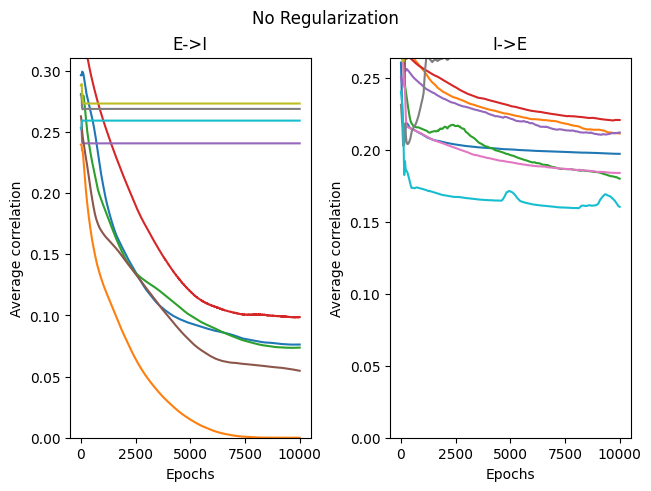

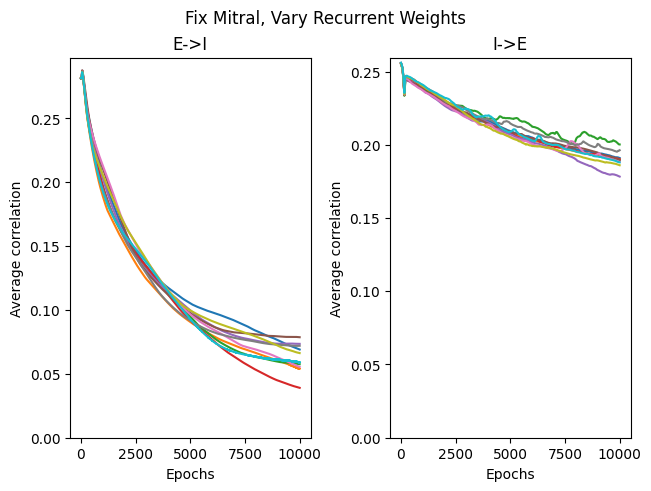

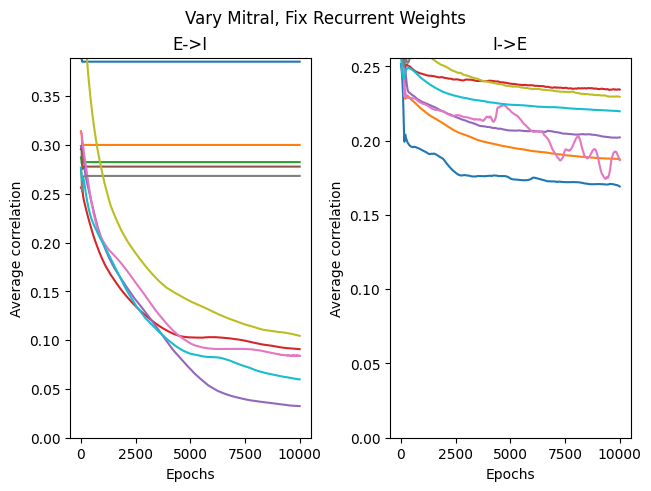

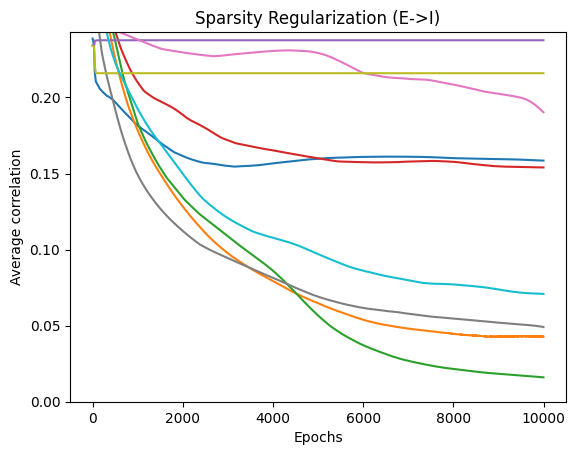

In [6]:
fig_std, ax_std = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
realization_type = f"./standard"
for i in range(10):
    ie_path = f"{realization_type}/ie/realization_{i}/data"
    ei_path = f"{realization_type}/ei/realization_{i}/data"
    plot_corrs(fig_std, ax_std, ie_path, ei_path)
fig_std.suptitle("No Regularization")
plt.show()    

fig_fix, ax_fix = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
realization_type = f"./fix_mitral"
for i in range(10):
    ie_path = f"{realization_type}/ie/realization_{i}/data"
    ei_path = f"{realization_type}/ei/realization_{i}/data"
    plot_corrs(fig_fix, ax_fix, ie_path, ei_path)
fig_fix.suptitle("Fix Mitral, Vary Recurrent Weights")
plt.show()

fig_vary, ax_vary = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
realization_type = f"./vary_mitral"
for i in range(10):
    ie_path = f"{realization_type}/ie/realization_{i}/data"
    ei_path = f"{realization_type}/ei/realization_{i}/data"
    plot_corrs(fig_vary, ax_vary, ie_path, ei_path)
fig_vary.suptitle("Vary Mitral, Fix Recurrent Weights")
plt.show()

realization_type = f"./sp_reg"
for i in range(10):
    ie_path = f"{realization_type}/ie/realization_{i}/data"
    ie_corrs = torch.load(f"{ie_path}/corrs.pt")
    plt.plot(torch.arange(epochs_inner), ie_corrs)
    plt.xlabel("Epochs")
    plt.ylabel("Average correlation")
    plt.ylim(bottom=0.)

plt.title("Sparsity Regularization (E->I)")
plt.show()

    

## Odor Correlation

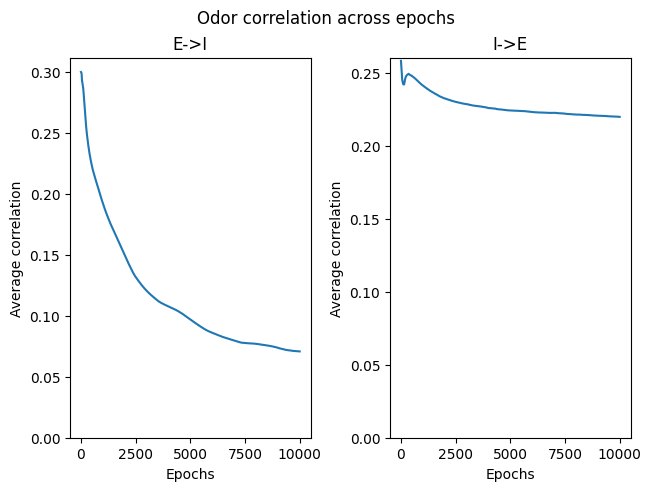

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
plot_corrs(fig, ax, ie_path, ei_path)
fig.suptitle("Odor correlation across epochs")

plt.show()

### Neuron Degree

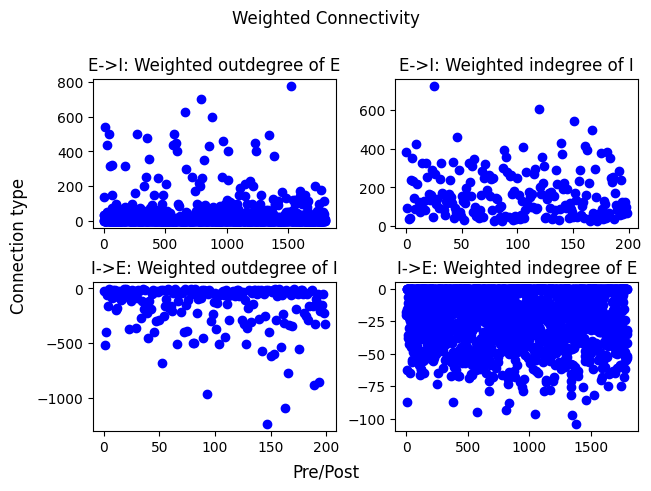

E->I: Nonzero excitatory neurons: 1091 out of 1800
E->I: Nonzero inhibitory neurons: 200 out of 200

I->E: Nonzero inhibitory neurons: 200 out of 200
I->E: Nonzero excitatory neurons: 1106 out of 1800


In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)

# IE

W_ie = W_ie_trained[num_e:, :num_e].detach().cpu()
ax[0, 0].plot(torch.sum(W_ie, dim=0), "bo")
ax[0, 0].set_title("E->I: Weighted outdegree of E")
ax[0, 1].plot(torch.sum(W_ie, dim=1), "bo")
ax[0, 1].set_title("E->I: Weighted indegree of I")

# EI

W_ei = W_ei_trained[:num_e, num_e:].detach().cpu()
ax[1, 0].plot(torch.sum(W_ei, dim=0), "bo")
ax[1, 0].set_title("I->E: Weighted outdegree of I")
ax[1, 1].plot(torch.sum(W_ei, dim=1), "bo")
ax[1, 1].set_title("I->E: Weighted indegree of E")

fig.supylabel("Connection type")
fig.supxlabel("Pre/Post")
fig.suptitle("Weighted Connectivity\n")

plt.show()

print(f"E->I: Nonzero excitatory neurons: {torch.count_nonzero(torch.sum(torch.abs(W_ie), dim=0) > 1e-1)} out of {num_e}")
print(f"E->I: Nonzero inhibitory neurons: {torch.count_nonzero(torch.sum(torch.abs(W_ie), dim=1) > 1e-1)} out of {num_i}")
print()
print(f"I->E: Nonzero inhibitory neurons: {torch.count_nonzero(torch.sum(torch.abs(W_ei), dim=0) > 1e-1)} out of {num_i}")
print(f"I->E: Nonzero excitatory neurons: {torch.count_nonzero(torch.sum(torch.abs(W_ei), dim=1) > 1e-1)} out of {num_e}")

### Sparsities

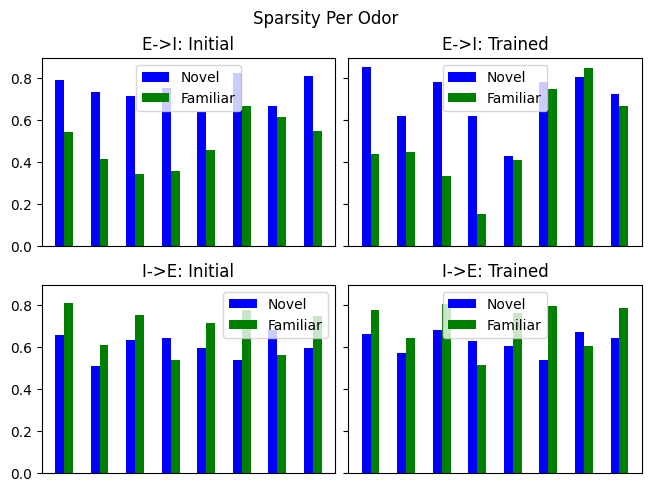

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, constrained_layout=True)
width = 0.25
x_p = torch.arange(P // 2)

# IE

ie_sp_odor_initial = sparsity_per_odor(R_ie_initial).detach().cpu()
ie_sp_odor_trained = sparsity_per_odor(R_ie_trained).detach().cpu()

ax[0, 0].bar(x_p, ie_sp_odor_initial[novel_inds].detach().cpu(), width=width, label="Novel", color="b")
ax[0, 0].bar(x_p + width, ie_sp_odor_initial[familiar_inds].detach().cpu(), width=width, label="Familiar", color="g")
ax[0, 0].legend()
ax[0, 0].set_xticks([])
ax[0, 0].set_title("E->I: Initial")
ax[0, 1].bar(x_p, ie_sp_odor_trained[novel_inds].detach().cpu(), width=width, label="Novel", color="b")
ax[0, 1].bar(x_p + width, ie_sp_odor_trained[familiar_inds].detach().cpu(), width=width, label="Familiar", color="g")
ax[0, 1].legend()
ax[0, 1].set_xticks([])
ax[0, 1].set_title("E->I: Trained")

# EI

ei_sp_odor_initial = sparsity_per_odor(R_ei_initial).detach().cpu()
ei_sp_odor_trained = sparsity_per_odor(R_ei_trained).detach().cpu()

ax[1, 0].bar(x_p, ei_sp_odor_initial[novel_inds].detach().cpu(), width=width, label="Novel", color="b")
ax[1, 0].bar(x_p + width, ei_sp_odor_initial[familiar_inds].detach().cpu(), width=width, label="Familiar", color="g")
ax[1, 0].legend()
ax[1, 0].set_xticks([])
ax[1, 0].set_title("I->E: Initial")
ax[1, 1].bar(x_p, ei_sp_odor_trained[novel_inds].detach().cpu(), width=width, label="Novel", color="b")
ax[1, 1].bar(x_p + width, ei_sp_odor_trained[familiar_inds].detach().cpu(), width=width, label="Familiar", color="g")
ax[1, 1].legend()
ax[1, 1].set_xticks([])
ax[1, 1].set_title("I->E: Trained")

fig.suptitle("Sparsity Per Odor")
plt.show()

# x_e = torch.arange(num_e)
# ax[0, 1].bar(x_e, sparsity_per_neuron(R_ie_initial, familiar_inds).detach().cpu(), width=width, label="Initial", color="b")
# ax[0, 1].bar(x_e + width, sparsity_per_neuron(R_ie_initial, familiar_inds).detach().cpu(), width=width, label="Initial", color="b")
# ax[0, 1].bar(x_e, sparsity_per_neuron(R_ie_trained, novel_inds).detach().cpu(), width=width, alpha=0.5, label="Trained", color="g")
# ax[0, 1].bar(x_e + width, sparsity_per_neuron(R_ie_trained, novel_inds).detach().cpu(), width=width, alpha=0.5, label="Trained", color="g")
# ax[0, 1].legend()
# ax[0, 1].set_title("E->I: Per Neuron")

# x_e = torch.arange(num_e)
# ax[1, 1].bar(x_e, sparsity_per_neuron(R_ei_initial, familiar_inds).detach().cpu(), width=width, label="Initial", color="b")
# ax[1, 1].bar(x_e + width, sparsity_per_neuron(R_ei_initial, familiar_inds).detach().cpu(), width=width, label="Initial", color="b")
# ax[1, 1].bar(x_e, sparsity_per_neuron(R_ei_trained, novel_inds).detach().cpu(), width=width, alpha=0.5, label="Trained", color="g")
# ax[1, 1].bar(x_e + width, sparsity_per_neuron(R_ei_trained, novel_inds).detach().cpu(), width=width, alpha=0.5, label="Trained", color="g")
# ax[1, 1].legend()
# ax[1, 1].set_title("I->E: Per Neuron")

### Odor Correlation <> Weight Values

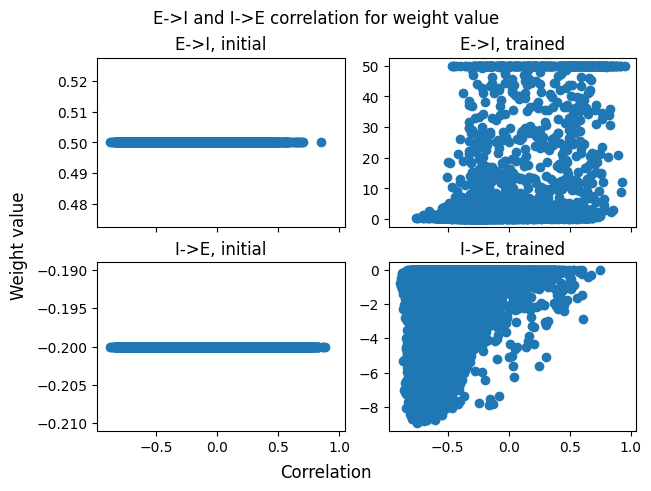

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, constrained_layout=True)

# IE

ie_initial_corrs = torch.corrcoef(R_ie_initial)[ie_update_inds].detach().cpu()
ie_initial_corrs, inds = torch.sort(ie_initial_corrs)
ax[0, 0].scatter(ie_initial_corrs, W_ie_initial[ie_update_inds][inds].detach().cpu())
ax[0, 0].set_title("E->I, initial")
ie_final_corrs = torch.corrcoef(R_ie_trained)[ie_update_inds].detach().cpu()
ie_final_corrs, inds = torch.sort(ie_final_corrs)
ax[0, 1].scatter(ie_final_corrs, W_ie_trained[ie_update_inds][inds].detach().cpu())
ax[0, 1].set_title("E->I, trained")

# EI

ei_initial_corrs = torch.corrcoef(R_ei_initial)[ei_update_inds].detach().cpu()
ei_initial_corrs, inds = torch.sort(ei_initial_corrs)
ax[1, 0].scatter(ei_initial_corrs, W_ei_initial[ei_update_inds][inds].detach().cpu())
ax[1, 0].set_title("I->E, initial")
ei_final_corrs = torch.corrcoef(R_ei_trained)[ei_update_inds].detach().cpu()
ei_final_corrs, inds = torch.sort(ei_final_corrs)
ax[1, 1].scatter(ei_final_corrs, W_ei_trained[ei_update_inds][inds].detach().cpu())
ax[1, 1].set_title("I->E, trained")

fig.supxlabel("Correlation")
fig.supylabel("Weight value")
fig.suptitle("E->I and I->E correlation for weight value")

plt.show()

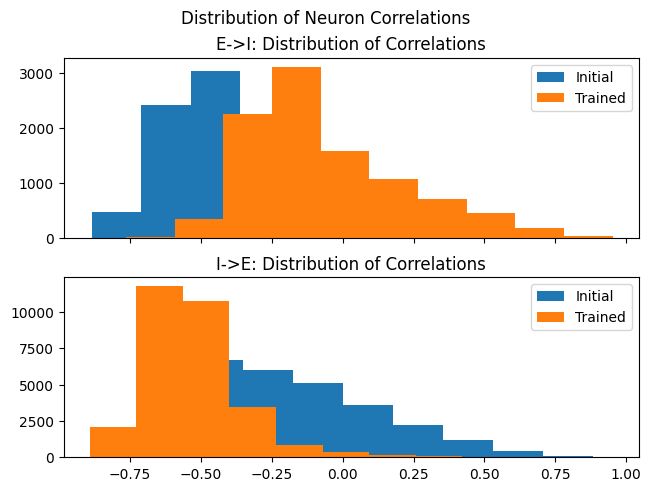

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, constrained_layout=True)

# IE
    
ax[0].hist(ie_initial_corrs, label="Initial")
ax[0].hist(ie_final_corrs, label="Trained")
ax[0].legend()
ax[0].set_title("E->I: Distribution of Correlations")

# EI

ax[1].hist(ei_initial_corrs, label="Initial")
ax[1].hist(ei_final_corrs, label="Trained")
ax[1].legend()
ax[1].set_title("I->E: Distribution of Correlations")

plt.suptitle("Distribution of Neuron Correlations")
plt.show()